# 5.1 Contour-based techniques for image segmentation

Image segmentation is the process of **assigning a label to every pixel in an image** such that pixels with the same label share certain characteristics. As a consequence, it produces regions whose pixels have similar properties (*e.g.* intensity, color, texture, or location in the image) which have a geometric and semantic meaning (see Fig.1). The result of image segmentation could be:
- a set of segments that collectively cover the entire image (e.g. thresholding), 
- or a set of contours extracted from the image (e.g. edge detection).

<figure style="text-align:center">
  <img src="./images/image-segmentation-example.png" width="550">
  <figcaption>Fig. 1: Example of image segmentation where each region corresponds to an object in the scene.</figcaption>
</figure>

Conceptually, two traditional approaches to image segmentation exist (see Fig. 2):
- **Top-down segmentation** *(semantic segmentation)*, which considers that pixels from the same object in the scene should be in the same segmented region.
- **Bottom-up segmentation** *(pixel-driven segmentation)*, which establishes that similar pixels in the image must be in the same segmented region. $\\[5pt]$

<figure style="text-align:center">
  <img img src="./images/bottom-up_top-down-segmentation.png" width="700">
  <figcaption>Fig. 2. An example of top-down and bottom-up approaches. Adopted from <a href="myfootnote1">[1]</a></figcaption>
</figure>

We put the spotlight here on bottom-up segmentation approaches. Methods following such approach can be grouped into:
- **Contour-based techniques**, which attempt to identify the image regions by detecting their contours.
- **Region-based techniques** that group together pixels that are similar. 


In this book we are going to experience both, starting with **contour-based techniques**, whose are based on detecting specific contours in the image (e.g. circles). In this context, image contours are defined as edge pixels that enclose a region.  

Contour-based techniques could be roughly classified into:
- **Local tecniques.** Try to segment regions by detecting closed contours, which typically enclose pixels with similar intensities.
   - LoG + zero crossing.
   - Edge following (Canny operator).
- **Global techniques.** Detect particular shapes in the image (circles, lines, etc.).
   - Hough transform. 
   
This notebook will cover the **Hough transform** (<a href="#511">section 5.1.1</a>), a contour-based technique that can be used for detecting regions with an arbitrary shape in images.

## Problem context - Self-driving car 

A prestigious company located at PTA (The Andalusia Technology Park) is organizing a [hackathon](https://en.wikipedia.org/wiki/Hackathon) for this year in order to motivate college students to make further progress in the autonomous cars field. Computer vision students at UMA decided to take part in it, but the organizers have posed an initial basic task to guarantee that participants have expertise in image processing techniques. 

This way, the company sent to students a task for **implementing a basic detector of road lane lines using OpenCV in python**. We are lucky! These are two tools that we know well ;).

Detecting lines in a lane is a fundamental task for autonomous vehicles while driving on the road. It is the building block to other path planning and control actions like breaking and steering. 

So here we are! We are going to detect road lane lines using Hough transform in OpenCV.$\\[5pt]$ 

<center><img src="./images/car.gif" width="400" align="center">$\\[10pt]$</center>

In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
images_path = './images/'

## 5.1.1 Hough transform <a id="511"></a>

The **Hough Transform** is a technique for the detection of arbitrary shapes in an image. For that, such shapes must be expressed in:

- analytical form (**classic Hough**), e.g. using the mathematical representation of lines, circles, ellipses, etc., or 
- in a numerical form (**generalized Hough**) where the shape is given by a table. 

Since our goal is to detect lines, we will focus here on analytically expressed shapes. Specifically, a line can be represented analytically as:

$$y = mx + n$$

or in its parametric form, as:

$$\rho = x \cos \theta + y \sin \theta$$

where $\rho$ is the perpendicular distance from the origin $(0,0)$ to the line, and $\theta$ is the angle formed by this perpendicular line and the horizontal axis measured in counter-clockwise (see Fig. 3). Thereby, we are going to represent lines using the pair of parameters $(\rho, \theta)$.

<figure style="text-align:center">
  <img src="./images/houghlines.svg" width="250">
  <figcaption>Fig. 3. Parametric representation of a line.</figcaption>
</figure>


The Hough transform works by a voting procedure, which is carried out in a parameter space ($\rho,\theta$ in our case). This technique consists of the following steps:

1. **Build an accumulator matrix**, where rows index the possible values of $\rho$, and columns those for $\theta$. For example, if the possible values for $\rho$ are $0, 1, 2, \ldots d$ (where $d$ is the max distance e.g. diagonal size of the image) and those for $\theta$ are $0, 1, 2 \ldots 179$, the matrix shape would be $(d,180)$.

In [2]:
# Define possible rho and theta values
theta_values = [0,np.pi/4,np.pi/2,3*np.pi/4]
rho_values = [0,1,2,3,4,5]

# Create the accumulator
acc = np.zeros([len(rho_values),len(theta_values)])

2. **Binarize the input image** to obtain pixels that are candidates to belong to the shape contours (e.g. by applying an edge detector).

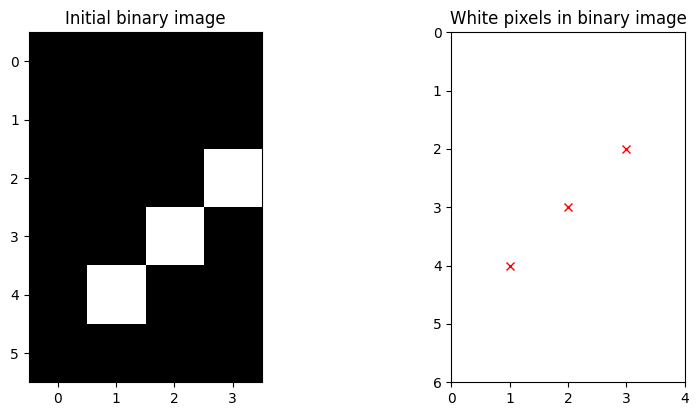

In [3]:
# Coordinates of white points in binary image
xs = np.array([1,2,3])
ys = np.array([4,3,2])

# Initial image
plt.subplot(221)
blank_image = np.zeros((6,4,1), np.uint8)
blank_image[ys,xs] = 255
plt.imshow(blank_image, cmap='gray');
plt.title('Initial binary image')

# Show them!
plt.subplot(222)
plt.plot(xs,ys,'rx')
plt.axis('scaled')    
axes = plt.gca()
axes.set_xlim([0,4])
axes.set_ylim([0,6])
plt.gca().invert_yaxis()
plt.title('White pixels in binary image');


3. For each candidate (white pixel):
   1. **Evaluate**: Since the point coordinates $(x,y)$ are known, place them in the line parametric form and iterate over the possible values of $\theta$ to obtain the values for $\rho$. In the previous example $\rho_i = x \cos \theta_i + y \sin \theta_i, \forall i\in[0,180]$
   2. **Vote**: For every obtained pair $(\rho_i, \theta_i)$ increment by one the value of its associated cell in the accumulator.

If we do this with an accumulator with an enough resolution, we would get a sinusoid.

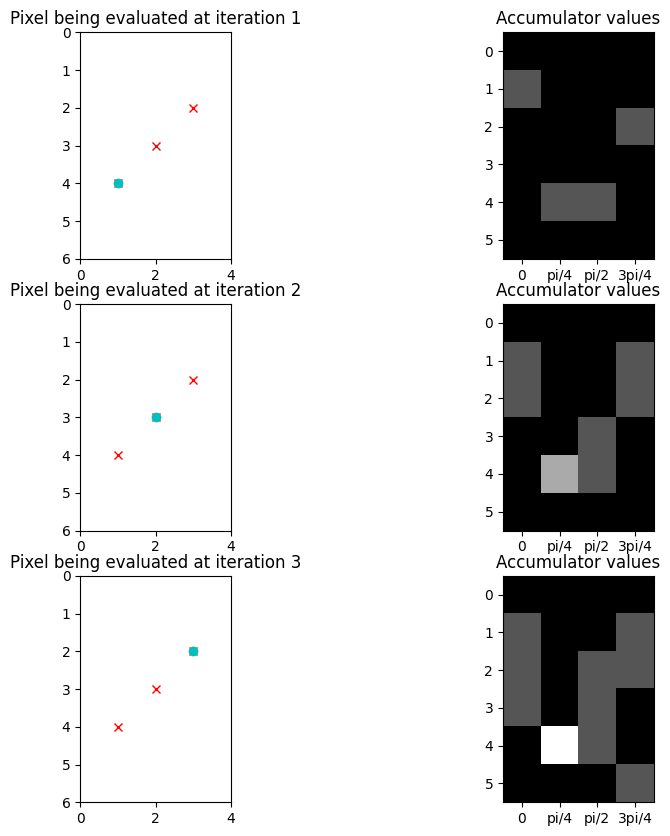

In [4]:
# For each white pixel

for i in range (0,len(xs)):
    x = xs[i]
    y = ys[i]
    
    # Show the point voting
    subplot_index = str(32) + str(i*2+1)
    plt.subplot(int(subplot_index))   
    plt.axis('scaled')    
    axes = plt.gca()
    axes.set_xlim([0,4])
    axes.set_ylim([0,6])
  
    plt.plot(xs,ys,'rx')
    plt.plot(x,y,'co')
    
    plt.title('Pixel being evaluated at iteration ' + str(i+1))
    plt.gca().invert_yaxis()
    
    
    # Ecaluate the (x,y) coordinates for different values of theta, and 
    # retrieve rho
    for theta_index in range(0,len(theta_values)):
        theta = theta_values[theta_index]
        rho = x*np.cos(theta) + y*np.sin(theta)
        rho = int(np.round(rho))
        # Vote!
        acc[rho][theta_index] += 1.0
        
    # Show the acccumulator
    subplot_index = str(32) + str(i*2+2)
    plt.subplot(int(subplot_index))        
    plt.imshow(acc,cmap='gray',vmax=3);    
    plt.xticks([0, 1, 2, 3], ['0','pi/4','pi/2','3pi/4'])
                                                       
    plt.title('Accumulator values')

4. Finally, **obtain the shape candidates** by setting a threshold to control how many votes needs a pair $(\rho, \theta)$  to be considered a line, and by applying local maxima in the accumulator space. $\\[10pt]$
  
<figure style="text-align:center">
  <img src="./images/houghlinesdemo.gif" width="400" align="center">
  <figcaption>Fig. 3. Left, image space. Right, parameter space illustrating the evolution of the votes. Note that in this example $\theta$ have only 8 possible values.</figcaption>
</figure>


The idea behind this algorithm is that when a pixel in the image space votes for all the lines that go through it in the parameter space, when a second pixel belonging to the same line votes, then the line connecting both pixels would have two votes. 

#### <font color="orange">OpenCV pill</font>
    
OpenCV implements the method [`cv2.HoughLines()`](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a) for detecting lines using the Hough transform. However, prior to its usage, and as commented in the `step 1.` of the algorithm, it is needed a binary image. For that we are going to resort to our old friend the Canny algorithm, so the detected edges will be the white pixes in the binary image.

As we now, noisy images seriously hamper the performance of computer vision techniques, and since [cv2.Canny()](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de) does not include blurring, we provide here a method called `gaussian_smoothing()` to assist you in that task.

In [5]:
def gaussian_smoothing(image, sigma, w_kernel):
    """ Blur and normalize input image.   
    
        Args:
            image: Input image to be binarized
            sigma: Standard deviation of the Gaussian distribution
            w_kernel: Kernel aperture size
                    
        Returns: 
            binarized: Blurred image
    """   
    
    # Define 1D kernel
    s=sigma
    w=w_kernel
    kernel_1D = [np.exp(-z*z/(2*s*s))/np.sqrt(2*np.pi*s*s) for z in range(-w,w+1)]
    
    # Apply distributive property of convolution
    kernel_2D = np.outer(kernel_1D,kernel_1D)
    
    # Blur image
    smoothed_img = cv2.filter2D(image,cv2.CV_8U,kernel_2D)
    
    # Normalize to [0 254] values
    smoothed_norm = np.array(image.shape)
    smoothed_norm = cv2.normalize(smoothed_img,None, 0, 255, cv2.NORM_MINMAX)
    
    return smoothed_norm

### **<span style="color:green"><b><i>ASSIGNMENT 1: Detecting lines with Hough</i></b></span>**

**Your first task is** to apply [`cv2.HoughLines()`](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a) to the image `car.png`, a test image taken from the frontal camera of a car. Draw the resultant lines using [`cv2.line()`](https://docs.opencv.org/4.2.0/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2).

The main inputs of `cv2.HoughLines()` are:

- *image*: binary input image
- *rho*: distance resolution of the accumulator in pixels (usually 1, it may be bigger for high resolution images) 
- *theta*: angle resolution of the accumulator in radians. (usually $\frac{\pi}{180}$)$\\[2pt]$
- *threshold*: only line candidates having a number of votes $>$ threshold are returned.

And it returns:
- a  $( n\_lines x 1 x 2 )$ array containing, in each row, the parameters of each detected line in the $[\rho,\theta]$ format.

*Note that, for drawing the lines, you have to [transform the resultant lines](https://answers.opencv.org/question/21132/draw-the-lines-detected-by-cvhoughlines/) from the $(\rho, \theta)$ space to Cartesian coordinates.*

Try different parameter values until you get something like this:

<figure style="text-align:center">
  <img src="./images/hough-lines-result.png" align="center">
  <figcaption>Fig. 4. Example of lines detection.</figcaption>
</figure>


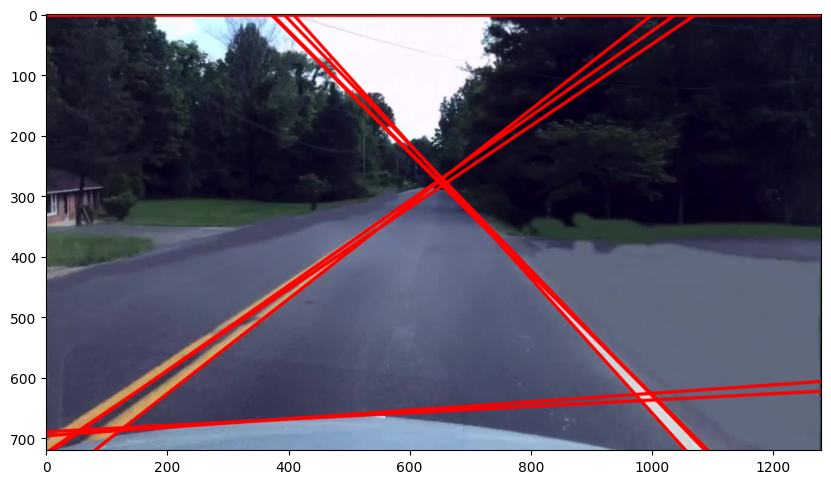

In [6]:
# Assignment 1
# Read the image
image = cv2.imread(images_path + "car.png",-1)

# Convert to RGB and get gray image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Blur the gray image
gray = gaussian_smoothing(gray,2,5)

# Apply Canny algorithm
edges = cv2.Canny(gray,100,200,apertureSize = 3)

# Search for lines using Hough transform
lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=150)

# For each line
for i in range(0, len(lines)):
    
    # Transform from polar coordinates to cartesian coordinates
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = rho * a
    y0 = rho * b
    
    # Get two points in that line 
    x1 = int(x0 + 2000*(-b));
    y1 = int(y0 + 2000*(a))
    pt1 = (x1,y1)
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    pt2 = (x2,y2)
    
    # Draw the line in the RGB image
    cv2.line(image, pt1, pt2, (255,0,0), 3, cv2.LINE_AA)

# Show resultant image
plt.imshow(image);

### 5.1.2.1 Probabilistic Hough transform

For high-resolution images and large accumulator sizes the Hough transform may need long execution times. However, in applications like autonomous cars a fast execution is mandatory. For example, having a car moving at 100km/h covers $\sim28$ meters in a second. Imagine how much lines can change in that time!

#### <font color="orange">OpenCV pill</font>
    
OpenCV provides with the method [`cv2.HoughLinesP()`](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb) a more complex implementation of the Hough Line Transform, which is called **probabilistic Hough Transform**. This alternative does not take all the points in the binary image into account, but a random subset of them that are still enough for line detection. This also results in lower thresholds when deciding if a line exists or not.  

### **<span style="color:green"><b><i>ASSIGNMENT 2: Another option for detecting lines</i></b></span>**

Apply [`cv2.HoughLinesP()`](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb) to the image `car.png` and draw the detected lines.

This function returns:
- line segments `[x1,y1,x2,y2]` instead of the line equation parameters.

For that, two additional arguments are needed:
- minLineLength: line segments shorter than that are rejected. 
- maxLineGap: maximum allowed gap between points on the same line to link them.

Try different parameter values until you get something like this:

<figure style="text-align:center">
  <img src="./images/probabilistic-hough-lines-result.png" align="center">
  <figcaption>Fig. 5. Lines detection example with the probabilistic Hough Transform.</figcaption>
</figure>



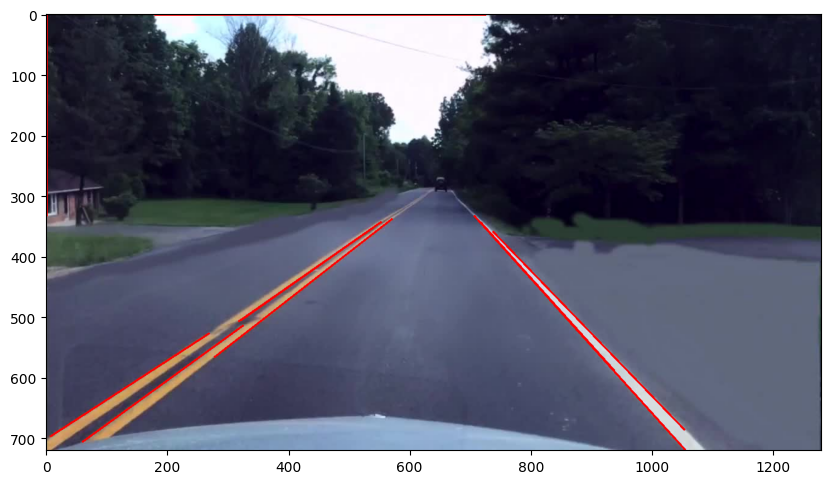

In [7]:
# Assigment 2
# Read the image
image = cv2.imread(images_path + "car.png",-1)

# Convert to RGB and get gray image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Blur the gray image
gray = gaussian_smoothing(gray,1,2)

# Apply Canny algorithm
edges = cv2.Canny(gray,100,200,apertureSize = 3)

# Search for lines using probabilistic Hough transform
rho = 1
theta = np.pi/180
threshold = 50
lines = cv2.HoughLinesP(edges, rho, theta, threshold,
                        minLineLength=200,maxLineGap=10)
# For each line
for line in lines:
    
    # Draw the line in the RGB image
    x1,y1,x2,y2 = line[0]
    cv2.line(image,(x1,y1),(x2,y2),(255,0,0),2)

# Show resultant image
plt.imshow(image);

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now that you have played with the Hough Transform, **answer the following questions**:

- In the first assignment, we obtained an image with a number of red lines drawn on it. However, these lines goes over pixels in the image that do not contains lines! (*e.g.* belonging to the sky). What could we do to fix this, that is, obtain the pixels belonging to lines in the image?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>La forma de solucionarlo sería escogiendo los puntos extremos que conforman la línea. De eso trata la vertiente probabilística del Hough (cv2.HoughLinesP)</i></p>
    
- Without restrictions regarding execution time, which method would you use, Hough Transform or its probabilistic counterpart?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Depende de la circunstancia, pero intentaría coger siempre la vertiente probabilística, pues nos da una información más exacta de cuales son las rectas en una imagen, su origen y su destino.</i></p> 
    
- Could there be a cell in the accumulator with a value higher than the number of white pixels in the binary image? why?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>No puede ocurrir, puesto que en el acumulador sólo votan los píxeles blancos. De forma que, el número máximo de votos que puede haber sobre una celda es el número de píxeles blancos. Esto ocurre cuando todos los píxeles votan un determinado $(\rho, \theta)$</i></p> 
    
- Which should be the maximum value for $\rho$ in the accumulator? Why?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>El $\rho$ es la distancia que hay desde una línea en la imagen y el punto de orígen. Por tanto, la distancia máxima entre el orígen y cualquier punto de la imágen siempre será la diagonal. Por tanto, el $\rho$ máximo será la diagonal de la imagen </i></p>     

### **<span style="color:green"><b><i>OPTIONAL</i></b></span>**

Think about any other application where the finding of straight lines could be useful. Get some images related to said application and detect lines with the Hough transform!

La transformada de Hough se puede aplicar a cualquier imagen en la que nos interese detectar contornos con líneas rectas. Un ejemplo que se ajusta bastante bien a lo especificado es encontrar las lineas rectas que hay en una imagen con un cubo de rubik.

Para visualiar correctamente las rectas de la imagen, utilizaré la variación probabilistica de la transformda de Hough


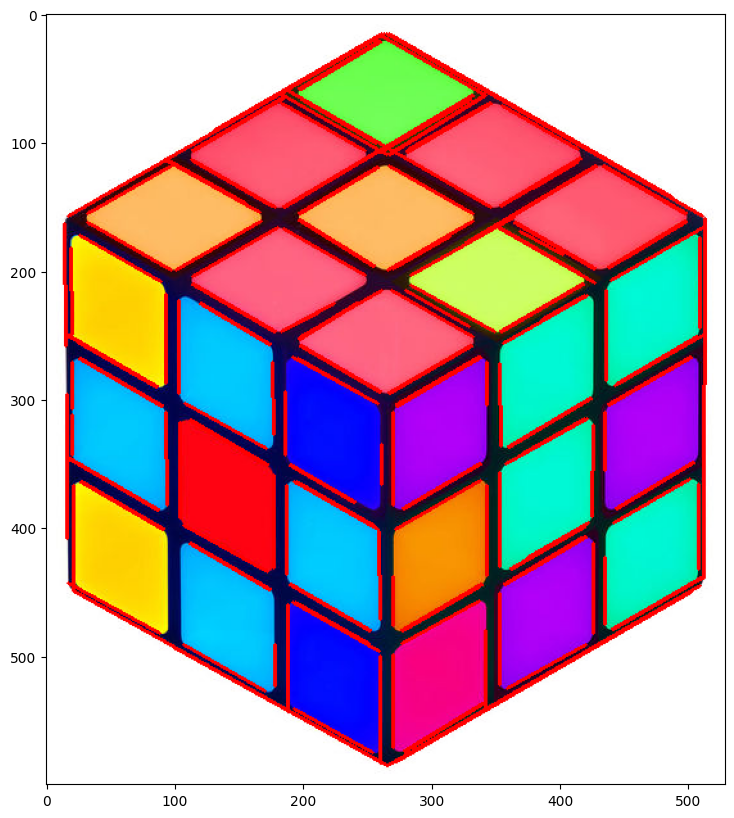

In [15]:
rubik = cv2.imread(images_path + "rubik.jpg",-1)

# Convert to RGB and get gray image
rubik = cv2.cvtColor(rubik, cv2.COLOR_BGR2RGB)
gray_rubik = cv2.cvtColor(rubik, cv2.COLOR_RGB2GRAY)

# Blur the gray image
gray_rubik = gaussian_smoothing(gray_rubik,0.5,1)

# Apply Canny algorithm
edges_rubik = cv2.Canny(gray_rubik,35, 100,apertureSize = 3)

# Search for lines using probabilistic Hough transform
rho = 1
theta = np.pi/180
threshold = 50
lines = cv2.HoughLinesP(edges_rubik, rho, theta, threshold,
                        minLineLength=20,maxLineGap=9)
# For each line
for line in lines:
    
    # Draw the line in the RGB image
    x1,y1,x2,y2 = line[0]
    cv2.line(rubik,(x1,y1),(x2,y2),(255,0,0),2)

# Show resultant image
#plt.imshow(edges_rubik,cmap = 'grey');
plt.imshow(rubik);

Para alcanzar este resultado he tenido que ajustar los parámetros de la gaussiana y del detector de Canny para obtener una buena imágen de bordes. Sin embargo, si quería obtener todos los cuadrados de la imágen tenía que aceptar cierta cantidad de ruido en la imagen.

Una vez obtenida la imagen de bordes, he aplicado la transformada de Hough para obtener las rectas.
Como hay líneas de poca longitud, he tenido que hacer los parámetros algo menos restrictivos.

### **<span style="color:green"><b><i>END OF OPTIONAL PART</i></b></span>**

## Conclusion

Terrific work! In the road lane lines detection context you have learned:
- to detect shapes in images using Hough transform .

Also, you obtained some knowledge about: 

- self-driving cars and computer vision, and
- lane line detection for autonomous cars.

See you in the next one! Keep learning!
